In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_shufflenetv2_ssdlayers_light_relu6_se_no_shuffle import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [5]:
import tensorflow as tf

run_meta = tf.RunMetadata()
with tf.Session(graph=tf.Graph()) as sess:
    K.set_session(sess)
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                input_tensor=tf.placeholder('float32', shape=(1,300,300,3)),
                mode='inference',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    opts = tf.profiler.ProfileOptionBuilder.trainable_variables_parameter()    
    params = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)
    
# Factor 1.5
print("{:,} --- {:,}".format(flops.total_float_ops/2, params.total_parameters))

596,843,577.5 --- 5,384,276


## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [ ]:
model.summary()

## Data generator for the training

In [6]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'images_reduced'

# Ground truth
# train_labels_filename = preprocess_path + '/cic_train_reduced.csv'
train_labels_filename = preprocess_path + '/cic_train_val_reduced.csv'
val_labels_filename   = preprocess_path + '/cic_val_reduced.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 45/45 [00:00<00:00, 378.52it/s]
Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


In [7]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv22_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


## Remaining training parameters

In [8]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 450:
        return 0.001
    else:
        return 0.0001

In [10]:
lr_list = [0.01, 0.001, 0.0001, 0.00001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/shufflenet_v2_ssdlayers_light_relu6_se_no_shuffle_factor_1.5.h5', by_name=True)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/noshufflese/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 165s 826ms/step - loss: 4.0598 - val_loss: 6.2726
Number of images: 1025
Presicion: 0.1425
Recall: 0.076
F1 score: 0.0992
F1 score: 0.09915137958112079
Improve F1 score from -inf to 0.09915137958112079
Epoch 2/100
200/200 [==============================] - 151s 756ms/step - loss: 3.8709 - val_loss: 4.1463
Number of images: 1025
Presicion: 0.2077
Recall: 0.3728
F1 score: 0.2667
F1 score: 0.2667306533068654
Improve F1 score from 0.09915137958112079 to 0.2667306533068654
Epoch 3/100
200/200 [==============================] - 146s 728ms/step - loss: 3.4698 - val_loss: 3.6220
Number of images: 1025
Presicion: 0.2997
Recall: 0.2776
F1 score: 0.2882
F1 score: 0.2881887472340263
Improve F1 score from 0.2667306533068654 to 0.2881887472340263
Epoch 4/100
200/200 [==============================] - 156s 782ms/step - loss: 3.3254 - val_loss: 3.5332
Number of images: 1025
Presicion: 0.2613
Recall: 0.2873
F

Number of images: 1025
Presicion: 0.3328
Recall: 0.2267
F1 score: 0.2697
F1 score: 0.2697197296236902
Epoch 39/100
200/200 [==============================] - 146s 729ms/step - loss: 2.1947 - val_loss: 3.2082
Number of images: 1025
Presicion: 0.3104
Recall: 0.3054
F1 score: 0.3079
F1 score: 0.3078589779510703
Epoch 40/100
200/200 [==============================] - 143s 715ms/step - loss: 2.1443 - val_loss: 2.9373
Number of images: 1025
Presicion: 0.3213
Recall: 0.2483
F1 score: 0.2801
F1 score: 0.28014212495552815
Epoch 41/100
200/200 [==============================] - 146s 730ms/step - loss: 2.1393 - val_loss: 2.9955
Number of images: 1025
Presicion: 0.3875
Recall: 0.2782
F1 score: 0.3239
F1 score: 0.3238934167999601
Improve F1 score from 0.3217922569567033 to 0.3238934167999601
Epoch 42/100
200/200 [==============================] - 143s 714ms/step - loss: 2.1242 - val_loss: 5.9124
Number of images: 1025
Presicion: 0.2587
Recall: 0.2554
F1 score: 0.257
F1 score: 0.25704616010144676
Ep

200/200 [==============================] - 146s 731ms/step - loss: 1.8041 - val_loss: 2.9809
Number of images: 1025
Presicion: 0.3321
Recall: 0.1928
F1 score: 0.2439
F1 score: 0.24394121318830037
Epoch 78/100
200/200 [==============================] - 144s 719ms/step - loss: 1.8058 - val_loss: 3.1869
Number of images: 1025
Presicion: 0.355
Recall: 0.2871
F1 score: 0.3175
F1 score: 0.3174770629953908
Epoch 79/100
200/200 [==============================] - 145s 723ms/step - loss: 1.8462 - val_loss: 2.7196
Number of images: 1025
Presicion: 0.3802
Recall: 0.2343
F1 score: 0.2899
F1 score: 0.2899325861047995
Epoch 80/100
200/200 [==============================] - 146s 731ms/step - loss: 1.7886 - val_loss: 2.7593
Number of images: 1025
Presicion: 0.3512
Recall: 0.3177
F1 score: 0.3336
F1 score: 0.3335959065173768
Improve F1 score from 0.33304748169996107 to 0.3335959065173768
Epoch 81/100
200/200 [==============================] - 147s 734ms/step - loss: 1.8182 - val_loss: 3.1800
Number of i

Number of images: 1025
Presicion: 0.576
Recall: 0.3352
F1 score: 0.4238
F1 score: 0.42381176160866507
Epoch 16/100
200/200 [==============================] - 145s 726ms/step - loss: 1.9311 - val_loss: 2.4133
Number of images: 1025
Presicion: 0.5616
Recall: 0.3761
F1 score: 0.4505
F1 score: 0.45049835296901686
Epoch 17/100
200/200 [==============================] - 144s 721ms/step - loss: 1.8834 - val_loss: 2.5414
Number of images: 1025
Presicion: 0.5413
Recall: 0.3493
F1 score: 0.4246
F1 score: 0.42464811877063746
Epoch 18/100
200/200 [==============================] - 146s 732ms/step - loss: 1.8780 - val_loss: 2.5584
Number of images: 1025
Presicion: 0.5185
Recall: 0.3764
F1 score: 0.4362
F1 score: 0.4361917390664329
Epoch 19/100
200/200 [==============================] - 145s 726ms/step - loss: 1.8390 - val_loss: 2.4172
Number of images: 1025
Presicion: 0.5205
Recall: 0.3866
F1 score: 0.4437
F1 score: 0.4436877875949395
Epoch 20/100
200/200 [==============================] - 146s 728

200/200 [==============================] - 143s 717ms/step - loss: 1.4881 - val_loss: 2.7560
Number of images: 1025
Presicion: 0.5403
Recall: 0.3079
F1 score: 0.3923
F1 score: 0.3922672904511012
Epoch 56/100
200/200 [==============================] - 147s 733ms/step - loss: 1.4867 - val_loss: 2.7321
Number of images: 1025
Presicion: 0.5598
Recall: 0.3057
F1 score: 0.3955
F1 score: 0.3954604763982811
Epoch 57/100
200/200 [==============================] - 147s 736ms/step - loss: 1.4812 - val_loss: 2.7393
Number of images: 1025
Presicion: 0.5315
Recall: 0.3221
F1 score: 0.4011
F1 score: 0.4011208008494121
Epoch 58/100
200/200 [==============================] - 144s 719ms/step - loss: 1.4537 - val_loss: 2.7583
Number of images: 1025
Presicion: 0.5318
Recall: 0.3352
F1 score: 0.4112
F1 score: 0.4112095805783072
Epoch 59/100
200/200 [==============================] - 144s 719ms/step - loss: 1.4517 - val_loss: 2.6854
Number of images: 1025
Presicion: 0.5095
Recall: 0.3199
F1 score: 0.393
F1 

Number of images: 1025
Presicion: 0.5608
Recall: 0.3021
F1 score: 0.3926
F1 score: 0.392648353071744
Epoch 95/100
200/200 [==============================] - 147s 737ms/step - loss: 1.3228 - val_loss: 2.7599
Number of images: 1025
Presicion: 0.562
Recall: 0.2785
F1 score: 0.3725
F1 score: 0.3724630079685695
Epoch 96/100
200/200 [==============================] - 145s 726ms/step - loss: 1.3159 - val_loss: 2.6971
Number of images: 1025
Presicion: 0.5683
Recall: 0.2858
F1 score: 0.3803
F1 score: 0.3802946627245749
Epoch 97/100
200/200 [==============================] - 143s 716ms/step - loss: 1.3413 - val_loss: 2.9031
Number of images: 1025
Presicion: 0.5149
Recall: 0.3264
F1 score: 0.3996
F1 score: 0.3995637903860957
Epoch 98/100
200/200 [==============================] - 141s 707ms/step - loss: 1.2832 - val_loss: 2.9560
Number of images: 1025
Presicion: 0.535
Recall: 0.3094
F1 score: 0.3921
F1 score: 0.3920874822321196
Epoch 99/100
200/200 [==============================] - 144s 720ms/st

200/200 [==============================] - 143s 716ms/step - loss: 2.2789 - val_loss: 2.4119
Number of images: 1025
Presicion: 0.5667
Recall: 0.457
F1 score: 0.506
F1 score: 0.5059756723423117
Epoch 35/100
200/200 [==============================] - 143s 716ms/step - loss: 2.2635 - val_loss: 2.4027
Number of images: 1025
Presicion: 0.5683
Recall: 0.454
F1 score: 0.5048
F1 score: 0.5047641231352666
Epoch 36/100
200/200 [==============================] - 145s 726ms/step - loss: 2.2761 - val_loss: 2.3948
Number of images: 1025
Presicion: 0.5612
Recall: 0.4655
F1 score: 0.5088
F1 score: 0.5088468677466262
Epoch 37/100
200/200 [==============================] - 149s 743ms/step - loss: 2.2452 - val_loss: 2.3982
Number of images: 1025
Presicion: 0.5638
Recall: 0.4558
F1 score: 0.5041
F1 score: 0.504074334293504
Epoch 38/100
200/200 [==============================] - 146s 732ms/step - loss: 2.2489 - val_loss: 2.3996
Number of images: 1025
Presicion: 0.5561
Recall: 0.4599
F1 score: 0.5035
F1 sco

Number of images: 1025
Presicion: 0.563
Recall: 0.4364
F1 score: 0.4917
F1 score: 0.4916757481575481
Epoch 74/100
200/200 [==============================] - 145s 726ms/step - loss: 1.9666 - val_loss: 2.3582
Number of images: 1025
Presicion: 0.5591
Recall: 0.4364
F1 score: 0.4902
F1 score: 0.49021074714005597
Epoch 75/100
200/200 [==============================] - 146s 731ms/step - loss: 1.9655 - val_loss: 2.3831
Number of images: 1025
Presicion: 0.557
Recall: 0.4365
F1 score: 0.4895
F1 score: 0.4894751080343841
Epoch 76/100
200/200 [==============================] - 144s 722ms/step - loss: 1.9463 - val_loss: 2.3747
Number of images: 1025
Presicion: 0.5699
Recall: 0.4322
F1 score: 0.4916
F1 score: 0.49159650634228635
Epoch 77/100
200/200 [==============================] - 147s 734ms/step - loss: 1.9163 - val_loss: 2.3687
Number of images: 1025
Presicion: 0.5658
Recall: 0.4325
F1 score: 0.4902
F1 score: 0.49020391795117474
Epoch 78/100
200/200 [==============================] - 148s 738m

200/200 [==============================] - 148s 741ms/step - loss: 3.4021 - val_loss: 3.2839
Number of images: 1025
Presicion: 0.6003
Recall: 0.5575
F1 score: 0.5781
F1 score: 0.5781257926243207
Epoch 13/100
200/200 [==============================] - 146s 731ms/step - loss: 3.3756 - val_loss: 3.2611
Number of images: 1025
Presicion: 0.6001
Recall: 0.5567
F1 score: 0.5776
F1 score: 0.5775505400069894
Epoch 14/100
200/200 [==============================] - 147s 735ms/step - loss: 3.3405 - val_loss: 3.2424
Number of images: 1025
Presicion: 0.6008
Recall: 0.5546
F1 score: 0.5768
F1 score: 0.5767919329056489
Epoch 15/100
200/200 [==============================] - 149s 744ms/step - loss: 3.3464 - val_loss: 3.2194
Number of images: 1025
Presicion: 0.5989
Recall: 0.5543
F1 score: 0.5758
F1 score: 0.5757523268522321
Epoch 16/100
200/200 [==============================] - 147s 734ms/step - loss: 3.3103 - val_loss: 3.1959
Number of images: 1025
Presicion: 0.5962
Recall: 0.5535
F1 score: 0.5741
F1

200/200 [==============================] - 145s 724ms/step - loss: 2.9463 - val_loss: 2.8037
Number of images: 1025
Presicion: 0.5737
Recall: 0.5323
F1 score: 0.5522
F1 score: 0.5522136438532773
Epoch 53/100
200/200 [==============================] - 146s 730ms/step - loss: 2.9845 - val_loss: 2.8028
Number of images: 1025
Presicion: 0.5763
Recall: 0.5323
F1 score: 0.5534
F1 score: 0.5534464359285097
Epoch 54/100
200/200 [==============================] - 146s 729ms/step - loss: 2.9222 - val_loss: 2.7991
Number of images: 1025
Presicion: 0.575
Recall: 0.5317
F1 score: 0.5525
F1 score: 0.5525190986003062
Epoch 55/100
200/200 [==============================] - 146s 730ms/step - loss: 2.9343 - val_loss: 2.7965
Number of images: 1025
Presicion: 0.575
Recall: 0.5317
F1 score: 0.5525
F1 score: 0.5525059994557318
Epoch 56/100
200/200 [==============================] - 149s 745ms/step - loss: 2.9251 - val_loss: 2.7942
Number of images: 1025
Presicion: 0.5729
Recall: 0.5304
F1 score: 0.5508
F1 s

Number of images: 1025
Presicion: 0.5655
Recall: 0.5164
F1 score: 0.5398
F1 score: 0.5398167592752513
Epoch 92/100
200/200 [==============================] - 147s 737ms/step - loss: 2.7431 - val_loss: 2.6711
Number of images: 1025
Presicion: 0.5675
Recall: 0.5167
F1 score: 0.5409
F1 score: 0.5409336809575662
Epoch 93/100
200/200 [==============================] - 145s 723ms/step - loss: 2.7354 - val_loss: 2.6711
Number of images: 1025
Presicion: 0.567
Recall: 0.5153
F1 score: 0.5399
F1 score: 0.5399310806818743
Epoch 94/100
200/200 [==============================] - 144s 720ms/step - loss: 2.7520 - val_loss: 2.6689
Number of images: 1025
Presicion: 0.5625
Recall: 0.5153
F1 score: 0.5378
F1 score: 0.5378252915618636
Epoch 95/100
200/200 [==============================] - 146s 729ms/step - loss: 2.7404 - val_loss: 2.6659
Number of images: 1025
Presicion: 0.5658
Recall: 0.5147
F1 score: 0.539
F1 score: 0.5390438647921483
Epoch 96/100
200/200 [==============================] - 143s 714ms/s

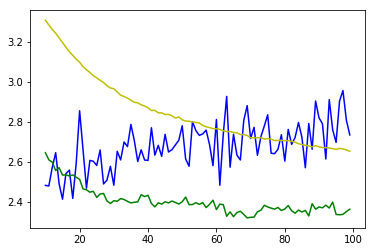

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
main_path = '/home/aldo/Downloads/noshufflese/'
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')
mob_00001 = pd.read_csv(main_path + 'model_1e-05.csv')


fig, ax = plt.subplots()
# ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')
ax.plot(mob_00001['epoch'][10:], mob_00001['val_loss'][10:], color='y')

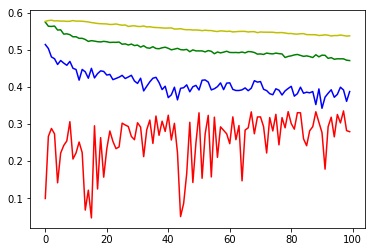

In [12]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')
mob_00001_f1 = pd.read_csv(main_path + 'f1_1e-05.csv')


fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')
ax.plot(mob_00001_f1['epoch'], mob_00001_f1['f1 score'], color='y')

In [9]:
scale_factors = [1.5]

for factor in scale_factors:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH FACTOR:', factor)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=factor,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/shufflenet_v2_ssdlayers_light_relu6_se_no_shuffle_factor_1.5.h5', by_name=True)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/CIC/shufflenet_v2_ssdlayers_light_relu6_se_no_shuffle_factor_' + 
                           str(factor) + '_4.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 600
    steps_per_epoch = 15

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/CIC/shufflenet_v2_ssdlayers_light_relu6_se_no_shuffle_factor_' + str(factor) + '_4.h5')

TRAINING MODEL WITH FACTOR: 1.5
Epoch 1/600

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 26s 2s/step - loss: 3.7195
Epoch 2/600

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 15s 1s/step - loss: 3.6074
Epoch 3/600

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 14s 935ms/step - loss: 3.4132
Epoch 4/600

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 854ms/step - loss: 3.2123
Epoch 5/600

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 14s 923ms/step - loss: 3.4476
Epoch 6/600

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 824ms/step - loss: 3.1075
Epoch 7/600

Epoch 00007: LearningRateScheduler setting learning rat

15/15 [==============================] - 13s 854ms/step - loss: 2.4030
Epoch 55/600

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 14s 923ms/step - loss: 2.4692
Epoch 56/600

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 877ms/step - loss: 2.4854
Epoch 57/600

Epoch 00057: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 864ms/step - loss: 2.5028
Epoch 58/600

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 894ms/step - loss: 2.4291
Epoch 59/600

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 14s 927ms/step - loss: 2.4813
Epoch 60/600

Epoch 00060: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 894ms/step - loss: 2.4113
Epoch 61/600

Epo

15/15 [==============================] - 13s 893ms/step - loss: 2.2279
Epoch 109/600

Epoch 00109: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 803ms/step - loss: 2.2238
Epoch 110/600

Epoch 00110: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 862ms/step - loss: 2.3137
Epoch 111/600

Epoch 00111: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 833ms/step - loss: 2.1525
Epoch 112/600

Epoch 00112: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 878ms/step - loss: 2.2117
Epoch 113/600

Epoch 00113: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 14s 925ms/step - loss: 2.1546
Epoch 114/600

Epoch 00114: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 881ms/step - loss: 2.1932
Epoch 115/6

15/15 [==============================] - 13s 852ms/step - loss: 2.0109
Epoch 163/600

Epoch 00163: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 817ms/step - loss: 1.9224
Epoch 164/600

Epoch 00164: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 824ms/step - loss: 1.9545
Epoch 165/600

Epoch 00165: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 874ms/step - loss: 1.9929
Epoch 166/600

Epoch 00166: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 877ms/step - loss: 2.0980
Epoch 167/600

Epoch 00167: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 889ms/step - loss: 1.9924
Epoch 168/600

Epoch 00168: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 866ms/step - loss: 1.9605
Epoch 169/6

15/15 [==============================] - 13s 842ms/step - loss: 1.8324
Epoch 217/600

Epoch 00217: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 867ms/step - loss: 1.9157
Epoch 218/600

Epoch 00218: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 871ms/step - loss: 1.9464
Epoch 219/600

Epoch 00219: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 809ms/step - loss: 1.9788
Epoch 220/600

Epoch 00220: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 799ms/step - loss: 1.7974
Epoch 221/600

Epoch 00221: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 771ms/step - loss: 1.8191
Epoch 222/600

Epoch 00222: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 830ms/step - loss: 1.8810
Epoch 223/6

15/15 [==============================] - 12s 827ms/step - loss: 1.9012
Epoch 271/600

Epoch 00271: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 869ms/step - loss: 1.7805
Epoch 272/600

Epoch 00272: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 858ms/step - loss: 1.8631
Epoch 273/600

Epoch 00273: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 867ms/step - loss: 1.8681
Epoch 274/600

Epoch 00274: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 859ms/step - loss: 1.8523
Epoch 275/600

Epoch 00275: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 861ms/step - loss: 1.7833
Epoch 276/600

Epoch 00276: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 872ms/step - loss: 1.8405
Epoch 277/6

15/15 [==============================] - 13s 845ms/step - loss: 1.6502
Epoch 325/600

Epoch 00325: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 826ms/step - loss: 1.7541
Epoch 326/600

Epoch 00326: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 878ms/step - loss: 1.7221
Epoch 327/600

Epoch 00327: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 867ms/step - loss: 1.8383
Epoch 328/600

Epoch 00328: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 867ms/step - loss: 1.7222
Epoch 329/600

Epoch 00329: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 864ms/step - loss: 1.8664
Epoch 330/600

Epoch 00330: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 868ms/step - loss: 1.8250
Epoch 331/6

15/15 [==============================] - 13s 869ms/step - loss: 1.8081
Epoch 379/600

Epoch 00379: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 857ms/step - loss: 1.7765
Epoch 380/600

Epoch 00380: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 14s 904ms/step - loss: 1.7353
Epoch 381/600

Epoch 00381: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 895ms/step - loss: 1.7476
Epoch 382/600

Epoch 00382: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 887ms/step - loss: 1.7487
Epoch 383/600

Epoch 00383: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 875ms/step - loss: 1.6249
Epoch 384/600

Epoch 00384: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 856ms/step - loss: 1.6418
Epoch 385/6

15/15 [==============================] - 14s 954ms/step - loss: 1.6987
Epoch 433/600

Epoch 00433: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 14s 920ms/step - loss: 1.7634
Epoch 434/600

Epoch 00434: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 886ms/step - loss: 1.6654
Epoch 435/600

Epoch 00435: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 888ms/step - loss: 1.6854
Epoch 436/600

Epoch 00436: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 869ms/step - loss: 1.6876
Epoch 437/600

Epoch 00437: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 14s 920ms/step - loss: 1.7524
Epoch 438/600

Epoch 00438: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 13s 888ms/step - loss: 1.7013
Epoch 439/6

15/15 [==============================] - 13s 875ms/step - loss: 1.5104
Epoch 486/600

Epoch 00486: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 879ms/step - loss: 1.6399
Epoch 487/600

Epoch 00487: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 864ms/step - loss: 1.5769
Epoch 488/600

Epoch 00488: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 876ms/step - loss: 1.5154
Epoch 489/600

Epoch 00489: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 878ms/step - loss: 1.4800
Epoch 490/600

Epoch 00490: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 872ms/step - loss: 1.4925
Epoch 491/600

Epoch 00491: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 846ms/step - loss: 1.4755
Epoch

15/15 [==============================] - 13s 834ms/step - loss: 1.5463
Epoch 539/600

Epoch 00539: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 854ms/step - loss: 1.4967
Epoch 540/600

Epoch 00540: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 838ms/step - loss: 1.4207
Epoch 541/600

Epoch 00541: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 12s 826ms/step - loss: 1.3947
Epoch 542/600

Epoch 00542: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 859ms/step - loss: 1.5765
Epoch 543/600

Epoch 00543: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 12s 831ms/step - loss: 1.5462
Epoch 544/600

Epoch 00544: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 834ms/step - loss: 1.5130
Epoch

15/15 [==============================] - 13s 861ms/step - loss: 1.5155
Epoch 592/600

Epoch 00592: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 891ms/step - loss: 1.4961
Epoch 593/600

Epoch 00593: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 12s 832ms/step - loss: 1.4943
Epoch 594/600

Epoch 00594: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 12s 815ms/step - loss: 1.5083
Epoch 595/600

Epoch 00595: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 12s 817ms/step - loss: 1.5021
Epoch 596/600

Epoch 00596: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 856ms/step - loss: 1.5099
Epoch 597/600

Epoch 00597: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 13s 864ms/step - loss: 1.4755
Epoch